In [7]:
from pydantic import Field,BaseModel
from typing import List

class State(BaseModel):
    thoughts: List[str] = Field(description = "A list of procedures developed by AI dynamically based on the context given")




In [9]:
import osmnx as ox

# Use place name to get boundary polygon
aoi = ox.geocode_to_gdf("Hassan,Karnataka, India")
aoi.to_file("aoi_boundary.geojson", driver="GeoJSON")


In [10]:
import geopandas as gpd
gdf = gpd.read_file("aoi_boundary.geojson")

In [11]:
import leafmap

m = leafmap.Map()
m.add_gdf(gdf, layer_name="AOI Boundary")
m.add_basemap("OpenStreetMap")
m.to_html("aoi_preview.html")


OpenStreetMap has been already added before.


In [16]:
import osmnx as ox
import leafmap
from shapely.geometry import box

# Step 1: Get AOI geometry
aoi_gdf = ox.geocode_to_gdf(" hassan , Karanataka, India")
bounds = aoi_gdf.total_bounds  # [minx, miny, maxx, maxy]

# Step 2: Calculate center coordinates
minx, miny, maxx, maxy = bounds
center_lat = (miny + maxy) / 2
center_lon = (minx + maxx) / 2

# Step 3: Create a zoomed-in map
m = leafmap.Map(center=[center_lat, center_lon], zoom=13)  # adjust zoom as needed
m.add_basemap("OpenStreetMap")
m.add_gdf(aoi_gdf, layer_name="AOI Boundary")

# Step 4: Save and open
output_file = "aoi_preview_zoomed.html"
m.to_html(output_file)

# Step 5: Open in browser
import webbrowser, os
webbrowser.open(f"file://{os.path.abspath(output_file)}")


OpenStreetMap has been already added before.


True

In [1]:
import osmnx as ox
import leafmap
from shapely.geometry import box
import webbrowser, os



def get_basemap(location:str):
    # Step 1: Get AOI geometry
    aoi_gdf = ox.geocode_to_gdf(location)
    bounds = aoi_gdf.total_bounds  # [minx, miny, maxx, maxy]

    # Step 2: Calculate center coordinates
    minx, miny, maxx, maxy = bounds
    center_lat = (miny + maxy) / 2
    center_lon = (minx + maxx) / 2

    # Step 3: Create a zoomed-in map
    m = leafmap.Map(center=[center_lat, center_lon], zoom=13)  # adjust zoom as needed
    m.add_basemap("OpenStreetMap")
    m.add_gdf(aoi_gdf, layer_name="AOI Boundary")

    # Step 4: Save and open
    output_file = "aoi_preview_zoomed.html"
    m.to_html(output_file)

    # Step 5: Open in browser

    webbrowser.open(f"file://{os.path.abspath(output_file)}")
    return  m


In [2]:
get_basemap("Hassan , Karnataka , India")

OpenStreetMap has been already added before.


Map(center=[np.float64(13.03018905), np.float64(76.09413105)], controls=(ZoomControl(options=['position', 'zoo…

In [3]:
# fetching dem import requests
import requests
from dotenv import load_dotenv

load_dotenv()
import os


def fetch_srtm_dem(bbox, output_path="dem.tif", dem_type="SRTMGL1"):
    minx, miny, maxx, maxy = bbox

    url = "https://portal.opentopography.org/API/globaldem"
    params = {
        "demtype": dem_type,
        "south": miny,
        "north": maxy,
        "west": minx,
        "east": maxx,
        "outputFormat": "GTiff",
        "API_Key": os.getenv("OPENTELEGRAPHY_API_KEY")
    }

    print(f"Requesting DEM for {bbox} from {dem_type}...")

    r = requests.get(url, params=params)
    if r.status_code != 200:
        raise Exception(f"DEM fetch failed: {r.text}")

    with open(output_path, "wb") as f:
        f.write(r.content)

    return output_path


In [4]:
bbox = [80.20, 13.05, 80.35, 13.20]  # Chennai
fetch_srtm_dem(bbox, output_path="chennai_dem.tif")


Requesting DEM for [80.2, 13.05, 80.35, 13.2] from SRTMGL1...


'chennai_dem.tif'

In [5]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open("chennai_dem.tif") as src:
    dem_data = src.read(1)  # Read the first band
    profile = src.profile
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

print(profile)  # Shows metadata like CRS, resolution, etc.


{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 540, 'height': 540, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0002777777777778146, 0.0, 80.1998611111456,
       0.0, -0.0002777777777778146, 13.200138888882691), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


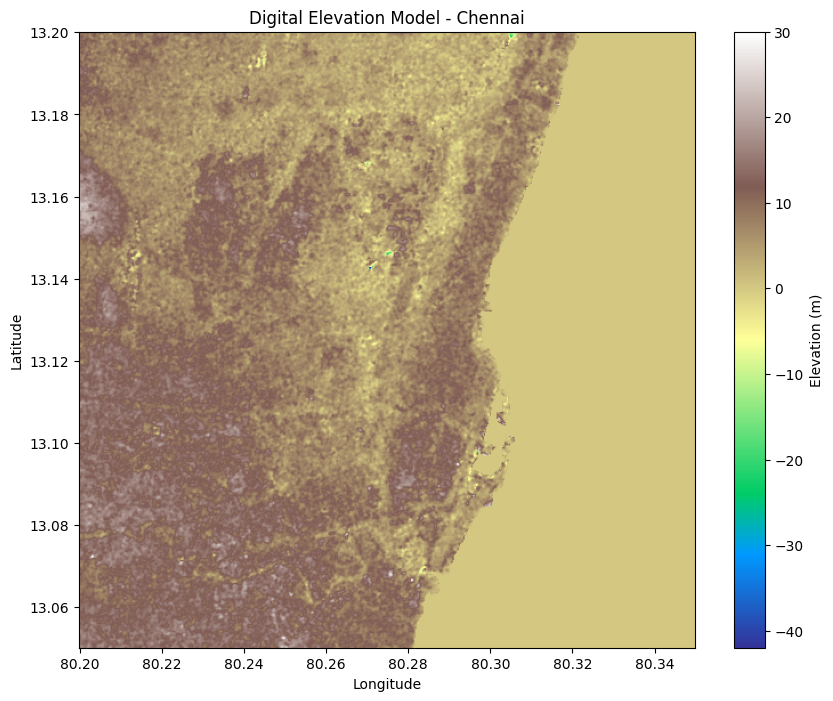

In [8]:
plt.figure(figsize=(10, 8))
plt.imshow(dem_data, cmap='terrain', extent=extent)
plt.colorbar(label="Elevation (m)")
plt.title("Digital Elevation Model - Chennai")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


🔍 Getting coordinates for: Chennai, India
📡 Fetching rainfall data from NASA POWER API...
✅ Rainfall data saved to rainfall_nasa_power.csv


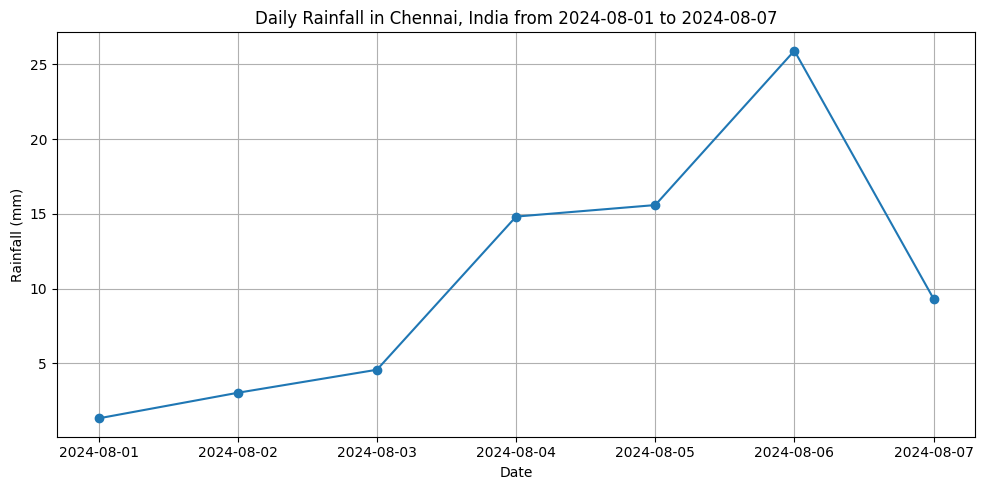

In [9]:
import requests
from pathlib import Path
from datetime import datetime
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import pandas as pd

# Convert place name to lat/lon
def get_latlon_from_location(place):
    geolocator = Nominatim(user_agent="nasa-power-rainfall")
    location = geolocator.geocode(place, timeout=10)
    if not location:
        raise ValueError("Location not found")
    return location.latitude, location.longitude

# Fetch rainfall using NASA POWER API
def fetch_rainfall_nasa_power(place, start_date, end_date):
    print(f"🔍 Getting coordinates for: {place}")
    lat, lon = get_latlon_from_location(place)

    # Format dates to YYYYMMDD integers
    start_fmt = datetime.strptime(start_date, "%Y-%m-%d").strftime("%Y%m%d")
    end_fmt = datetime.strptime(end_date, "%Y-%m-%d").strftime("%Y%m%d")

    url = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=PRECTOTCORR"
        f"&community=RE&latitude={lat}&longitude={lon}&start={start_fmt}&end={end_fmt}&format=JSON"
    )

    print(f"📡 Fetching rainfall data from NASA POWER API...")
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code}\n{response.text}")

    data = response.json()
    if 'PRECTOTCORR' not in data['properties']['parameter']:
        raise KeyError("Rainfall data 'PRECTOTCORR' not found in response")

    rain_data = data['properties']['parameter']['PRECTOTCORR']
    dates = list(rain_data.keys())
    values = list(rain_data.values())

    df = pd.DataFrame({"Date": pd.to_datetime(dates), "Rainfall (mm)": values})
    df.to_csv("rainfall_nasa_power.csv", index=False)
    print("✅ Rainfall data saved to rainfall_nasa_power.csv")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['Rainfall (mm)'], marker='o', linestyle='-')
    plt.title(f"Daily Rainfall in {place} from {start_date} to {end_date}")
    plt.xlabel("Date")
    plt.ylabel("Rainfall (mm)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
fetch_rainfall_nasa_power("Chennai, India", "2024-08-01", "2024-08-07")


In [15]:
import os
import requests
import gzip
import shutil
import datetime
from tqdm import tqdm
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
from geopy.geocoders import Nominatim
import numpy as np

def geocode_location(location_name):
    geolocator = Nominatim(user_agent="chirps_tool")
    loc = geolocator.geocode(location_name)
    if not loc:
        raise ValueError(f"Location not found: {location_name}")
    buffer_deg = 0.2  # about 20km x 20km area
    return box(loc.longitude - buffer_deg, loc.latitude - buffer_deg,
               loc.longitude + buffer_deg, loc.latitude + buffer_deg)

def download_chirps_tif(date: str, output_dir='data'):
    os.makedirs(output_dir, exist_ok=True)
    y, m, d = date.split('-')
    filename = f"chirps-v2.0.{y}.{m}.{d}.tif.gz"
    url = f"https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/tifs/{filename}"
    gz_path = os.path.join(output_dir, filename)
    tif_path = gz_path[:-3]

    if os.path.exists(tif_path):
        return tif_path

    r = requests.get(url, stream=True)
    if r.status_code != 200:
        raise Exception(f"Download failed for {url}")
    with open(gz_path, 'wb') as f:
        for chunk in tqdm(r.iter_content(1024), desc="Downloading"):
            f.write(chunk)
    with gzip.open(gz_path, 'rb') as f_in, open(tif_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
    os.remove(gz_path)
    return tif_path

def clip_raster(tif_path, geometry, output_path):
    with rasterio.open(tif_path) as src:
        out_image, out_transform = mask(src, [geometry], crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_image)
    return output_path

def compute_total_rainfall(tif_path):
    with rasterio.open(tif_path) as src:
        arr = src.read(1)
        arr = np.where(arr == src.nodata, 0, arr)
        return float(arr.sum())

def process_location_rainfall(location_name: str, date: str, out_dir='output'):
    os.makedirs(out_dir, exist_ok=True)
    print(f"\n📍 Processing: {location_name} | 📅 {date}")
    
    roi = geocode_location(location_name)
    tif = download_chirps_tif(date, output_dir=out_dir)
    clipped_tif = os.path.join(out_dir, f"{location_name.replace(' ', '_')}_{date}.tif")
    clip_raster(tif, roi, clipped_tif)
    rainfall_mm = compute_total_rainfall(clipped_tif)

    print(f"✅ Total Rainfall in '{location_name}' on {date}: {rainfall_mm:.2f} mm")
    return {
        "location": location_name,
        "date": date,
        "rainfall_mm": rainfall_mm,
        "clipped_tif": clipped_tif
    }

# 🧪 Example usage
if __name__ == "__main__":
    result = process_location_rainfall("Bangalore", "2024-08-15")



📍 Processing: Bangalore | 📅 2024-08-15


Exception: Download failed for https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/tifs/chirps-v2.0.2024.08.15.tif.gz

In [16]:
!wget https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/tifs/chirps-v2.0.2024.08.15.tif.gz
!gunzip chirps-v2.0.2024.08.15.tif.gz


OSError: "/usr/bin/fish" shell not found

In [24]:
import os
import requests
import gzip
import shutil
from datetime import datetime, timedelta
from tqdm import tqdm

def download_chirps_tif(date: datetime, out_dir="chirps_tifs"):
    y, m, d = date.strftime("%Y"), date.strftime("%m"), date.strftime("%d")
    filename = f"chirps-v2.0.{y}.{m}.{d}.tif"
    url = f"https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/tifs/p25/{y}/{filename}.gz"

    gz_path = os.path.join(out_dir, filename + ".gz")
    tif_path = os.path.join(out_dir, filename)

    if os.path.exists(tif_path):
        print(f"✅ Already downloaded: {filename}")
        return tif_path

    os.makedirs(out_dir, exist_ok=True)
    r = requests.get(url, stream=True)
    if r.status_code != 200:
        print(f"❌ Failed: {url}")
        return None

    with open(gz_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

    with gzip.open(gz_path, "rb") as f_in, open(tif_path, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

    os.remove(gz_path)
    print(f"✅ Downloaded and extracted: {tif_path}")
    return tif_path

def batch_download_chirps(start_date: str, end_date: str, out_dir="chirps_tifs"):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    current = start
    today = datetime.utcnow().date()
    max_available = today - timedelta(days=3)

    while current <= end:
        if current.date() > max_available:
            print(f"⚠️ Skipping future/unavailable date: {current.strftime('%Y-%m-%d')}")
        else:
            download_chirps_tif(current, out_dir)
        current += timedelta(days=1)


In [25]:
batch_download_chirps("2025-05-25", "2025-05-31")


/tmp/ipykernel_6372/969172239.py:42: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = datetime.utcnow().date()


✅ Downloaded and extracted: chirps_tifs/chirps-v2.0.2025.05.25.tif
✅ Downloaded and extracted: chirps_tifs/chirps-v2.0.2025.05.26.tif
✅ Downloaded and extracted: chirps_tifs/chirps-v2.0.2025.05.27.tif
✅ Downloaded and extracted: chirps_tifs/chirps-v2.0.2025.05.28.tif
✅ Downloaded and extracted: chirps_tifs/chirps-v2.0.2025.05.29.tif
✅ Downloaded and extracted: chirps_tifs/chirps-v2.0.2025.05.30.tif
✅ Downloaded and extracted: chirps_tifs/chirps-v2.0.2025.05.31.tif


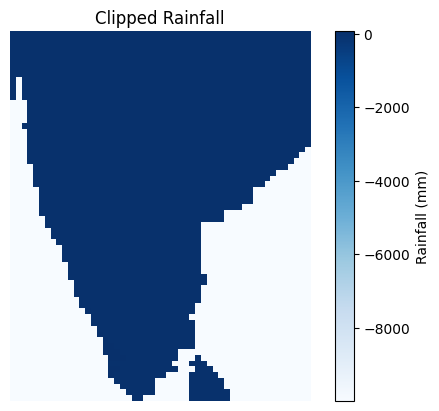

In [29]:
from rasterio.mask import mask
from shapely.geometry import box, mapping

def clip_tif(tif_path, bounds, out_path=None):
    with rasterio.open(tif_path) as src:
        bbox = box(*bounds)  # bounds: (minX, minY, maxX, maxY)
        out_image, out_transform = mask(src, [mapping(bbox)], crop=True)
        out_meta = src.meta.copy()

    if out_path:
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        with rasterio.open(out_path, "w", **out_meta) as dest:
            dest.write(out_image)
        return out_path
    else:
        return out_image[0]

# Example: Clip and visualize
bbox_chennai = (79.75, 12.9, 80.75, 13.3)
# Rough bounding box of peninsular India
rain_array = clip_tif("chirps_tifs/chirps-v2.0.2025.05.31.tif", bbox)
plt.imshow(rain_array, cmap="Blues")
plt.colorbar(label="Rainfall (mm)")
plt.title("Clipped Rainfall")
plt.axis("off")
plt.show()
